# **Data Collection**

Dataset "Stunting Toddler (Balita) Detection" ini kumpulan data berdasarkan rumus z-score penentuan stunting menurut WHO (World Health Organization), yang berfokus pada deteksi stunting pada balita (bayi dibawah lima tahun). Dataset ini terdiri dari 121.000 baris data, yang merinci informasi mengenai umur, jenis kelamin, tinggi badan, dan status gizi balita. Dataset ini bertujuan untuk membantu peneliti, ahli gizi, dan pembuat kebijakan dalam memahami dan mengatasi masalah stunting pada anak-anak di bawah lima tahun.

# **Rincian Kolom Dataset**

- Umur (Bulan): Mengindikasikan usia balita dalam bulan. Rentang usia ini penting untuk menentukan fase pertumbuhan anak dan membandingkannya dengan standar pertumbuhan yang sehat. (Umur 0 sampai 60 bulan)

- Jenis Kelamin: Terdapat dua kategori dalam kolom ini, 'laki-laki' (male) dan 'perempuan' (female). Jenis kelamin merupakan faktor penting dalam analisis pola pertumbuhan dan risiko stunting.

- Tinggi Badan: Dicatat dalam centimeter, tinggi badan adalah indikator utama untuk menilai pertumbuhan fisik balita. Data ini memungkinkan peneliti untuk menentukan apakah pertumbuhan anak sesuai dengan standar usianya.

- Status Gizi: Kolom ini dikategorikan menjadi 4 status - 'severely stunting', 'stunting', 'normal', dan 'tinggi'. 'Severely stunting' menunjukkan kondisi sangat serius (<-3 SD), 'stunting' menunjukkan kondisi stunting (-3 SD sd <-2 SD), 'normal' mengindikasikan status gizi yang sehat (-2 SD sd +3 SD), dan 'tinggi' (height) menunjukkan pertumbuhan di atas rata-rata (>+3 SD). Kategori ini membantu dalam identifikasi cepat dan intervensi bagi anak-anak yang berisiko atau mengalami masalah pertumbuhan.

Import Library

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflowjs as tfjs

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, models, callbacks

Dataset Load

In [2]:
file_id = "1Ers2Mz6Acp4MTgN7ryGU9_K2z8nD-syW"
url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(url)

# **Exploratory Data Analysis**

In [3]:
df.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [5]:
df.describe()

,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [6]:
df['Jenis Kelamin'].value_counts()

,count
Jenis Kelamin,
perempuan,61002
laki-laki,59997


In [7]:
df['Status Gizi'].value_counts()

,count
Status Gizi,
normal,67755
severely stunted,19869
tinggi,19560
stunted,13815


In [8]:
df.isnull().sum()

,0
Umur (bulan),0
Jenis Kelamin,0
Tinggi Badan (cm),0
Status Gizi,0


Text(0.5, 1.0, 'Distribusi Kelas Status Gizi')

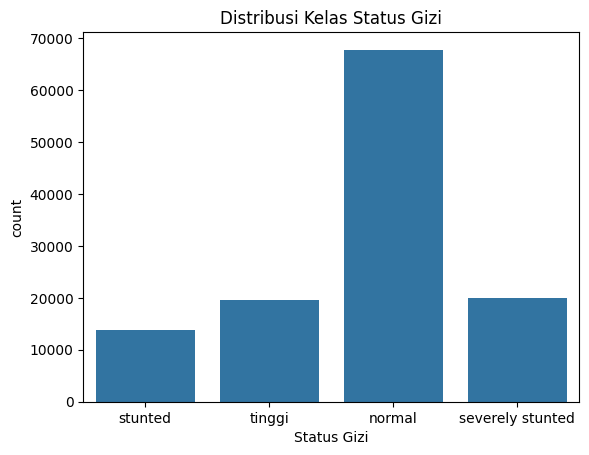

In [9]:
sns.countplot(x=df['Status Gizi'])
plt.title("Distribusi Kelas Status Gizi")

# **Data Preprocessing**

In [10]:
# LabelEncoder digunakan untuk mengubah label (target) kategori menjadi angka
le = LabelEncoder()
df['Status Gizi Encoded'] = le.fit_transform(df['Status Gizi'])

In [11]:
# Mengubah kolom kategorikal 'Jenis Kelamin' menjadi bentuk numerik dengan one-hot encoding
df = pd.get_dummies(df, columns=['Jenis Kelamin'])

In [12]:
# Menentukan fitur (X) dan target (y)
X = df[['Umur (bulan)', 'Tinggi Badan (cm)', 'Jenis Kelamin_laki-laki', 'Jenis Kelamin_perempuan']]
y = df['Status Gizi Encoded']

In [13]:
# Menstandarisasi fitur numerik agar memiliki mean 0 dan standar deviasi 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# Hitung korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=[np.number]).corr()

<Figure size 1000x800 with 0 Axes>

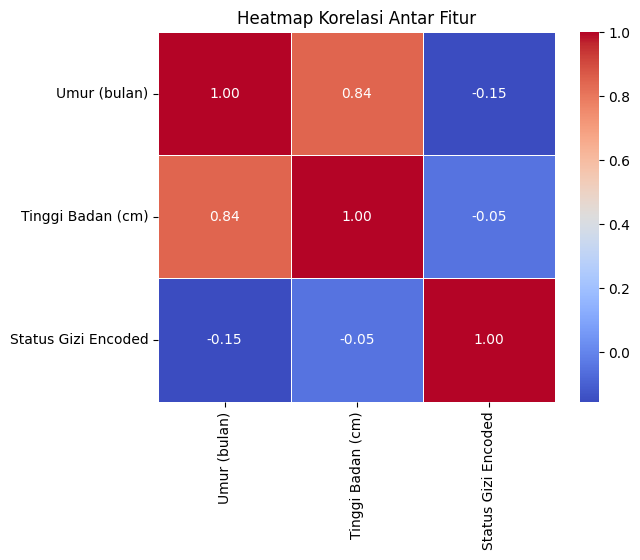

In [16]:
# Tampilkan heatmap korelasi
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

In [17]:
# Gabungkan label encoded dengan fitur numerik
corr_target = df.select_dtypes(include=[np.number]).copy()
corr_target['Status Gizi Encoded'] = df['Status Gizi Encoded']

# Korelasi terhadap label
target_corr = corr_target.corr()['Status Gizi Encoded'].sort_values(ascending=False)
print("Korelasi fitur terhadap status gizi:")
print(target_corr)

Korelasi fitur terhadap status gizi:
Status Gizi Encoded    1.000000
Tinggi Badan (cm)     -0.049534
Umur (bulan)          -0.154810
Name: Status Gizi Encoded, dtype: float64


In [18]:
df.head()

,Umur (bulan),Tinggi Badan (cm),Status Gizi,Status Gizi Encoded,Jenis Kelamin_laki-laki,Jenis Kelamin_perempuan
0,0,44.591973,stunted,2,True,False
1,0,56.705203,tinggi,3,True,False
2,0,46.863358,normal,0,True,False
3,0,47.508026,normal,0,True,False
4,0,42.743494,severely stunted,1,True,False


# **Model Training**

In [19]:
# Handling class imbalance dengan class weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights_dict = dict(zip(np.unique(y), class_weights))
print("Class Weight:", class_weights_dict)

Class Weight: {np.int64(0): np.float64(0.4464578259907018), np.int64(1): np.float64(1.5224596104484374), np.int64(2): np.float64(2.1896308360477743), np.int64(3): np.float64(1.546510736196319)}


In [20]:
# Buat model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # ada 4 kelas
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Callback untuk menghentikan training jika tidak ada peningkatan
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [23]:
# Training
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6203 - loss: 0.7486 - val_accuracy: 0.9021 - val_loss: 0.2489
Epoch 2/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8566 - loss: 0.3080 - val_accuracy: 0.9236 - val_loss: 0.1875
Epoch 3/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8846 - loss: 0.2470 - val_accuracy: 0.9286 - val_loss: 0.1760
Epoch 4/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8962 - loss: 0.2202 - val_accuracy: 0.9370 - val_loss: 0.1439
Epoch 5/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9041 - loss: 0.1982 - val_accuracy: 0.9499 - val_loss: 0.1272
Epoch 6/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9099 - loss: 0.1872 - val_accuracy: 0.9485 - val_loss: 0.1211
Epoch 7/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9176 - loss: 0.1718 - val_accuracy: 0.9533 - val_loss: 0.1146
Epoch 8/50
2420/2420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9212 - loss: 0.163

# **Model Evaluation**

In [24]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi Test: {acc:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Akurasi Test: 0.9693
757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
                  precision    recall  f1-score   support

          normal       0.99      0.97      0.98     13551
severely stunted       0.99      0.97      0.98      3974
         stunted       0.89      0.98      0.93      2763
          tinggi       0.95      0.96      0.96      3912

        accuracy                           0.97     24200
       macro avg       0.95      0.97      0.96     24200
    weighted avg       0.97      0.97      0.97     24200



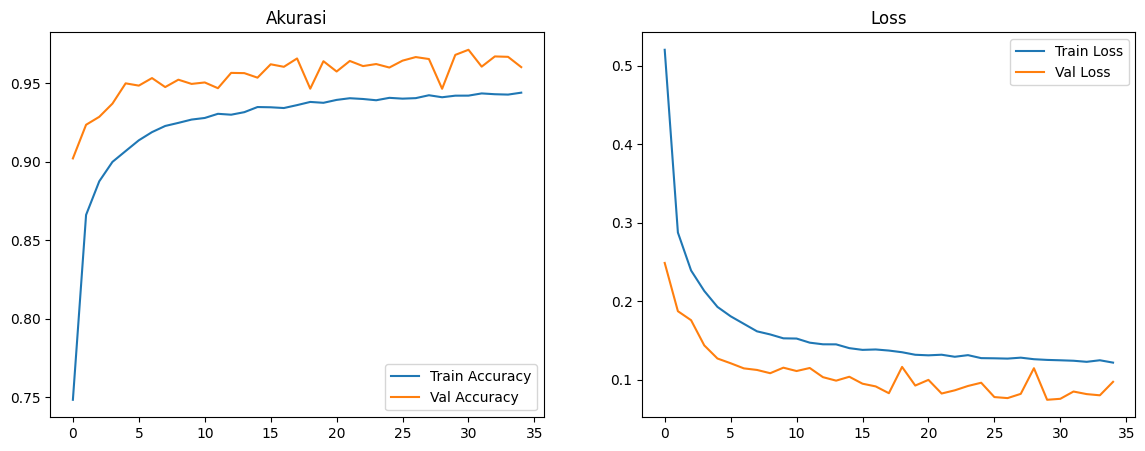

In [26]:
#Plot akurasi dan loss selama training
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# **Inference**

In [27]:
def prediksi_status_gizi():
    try:
        umur = int(input("Masukkan Umur (bulan):"))
        tinggi = int(input("Masukkan Tinggi Badan (cm):"))
        jenis_kelamin = input("Masukkan Jenis Kelamin ('laki-laki' atau 'perempuan'):").strip().lower()

      # Validasi jenis kelamin
        if jenis_kelamin == 'laki-laki':
            jk_laki = 1
            jk_perempuan = 0
        elif jenis_kelamin == 'perempuan':
            jk_laki = 0
            jk_perempuan = 1
        else:
            print("Jenis kelamin tidak valid")
            return

        input_data = np.array([[umur, tinggi, jk_laki, jk_perempuan]])
        input_scaled = scaler.transform(input_data)

        # Prediksi
        pred_prob = model.predict(input_scaled)
        pred_class = np.argmax(pred_prob, axis=1)
        status_gizi = le.inverse_transform(pred_class)

        print(f"\nHasil Prediksi Status Gizi: {status_gizi[0]}")

    except ValueError:
        print("Input tidak valid.")

prediksi_status_gizi()

Masukkan Umur (bulan):24
Masukkan Tinggi Badan (cm):40
Masukkan Jenis Kelamin ('laki-laki' atau 'perempuan'):perempuan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Hasil Prediksi Status Gizi: severely stunted


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# **Save & Convert Model**

In [28]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [29]:
model.save('nutriedu_model.h5')

In [32]:
from google.colab import files
uploaded = files.upload()

import os
os.makedirs('tfjs_model', exist_ok=True)

# Load model keras
model = tf.keras.models.load_model('nutriedu_model.h5')

# Convert dan simpan ke folder tfjs_model/
tfjs.converters.save_keras_model(model, 'tfjs_model')

Saving nutriedu_model.h5 to nutriedu_model (1).h5
failed to lookup keras version from the file,
    this is likely a weight only file


In [33]:
!zip -r tfjs_model.zip tfjs_model
files.download('tfjs_model.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 5%)
  adding: tfjs_model/model.json (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>